In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

In [15]:
class Value:
    def __init__(self, data, _children=(), _operation="", label=""):
        self.data = data
        self.grad = 0.0
        # function to perform chain rule
        self._backward = lambda: None
        # set for efficiency
        self._prev = set(_children)
        self._operation = _operation
        self.label = label

    def __add__(self, other):
        # a = Value(1), to call a + 2 we need to convert 2 to Value
        other = other if isinstance(other, Value) else Value(other)
        output =  Value(self.data + other.data, (self, other), "+")

        # chain rule for addition
        # local derivative (in this case 1) * output gradient, we just propagate the gradient
        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad

        output._backward = _backward

        return output
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        # a = Value(1), to call a * 2 we need to convert 2 to Value
        # but 2 * a will not work, so we need to implement __rmul__
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), "*")

        # chain rule for multiplication
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
        
        output._backward = _backward

        return output

    # it is like fallback for __mul__
    # 2 * a will call a.__rmul__(2)
    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be a number"
        output = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data**(other - 1) * output.grad
        
        output._backward = _backward

        return output

    def __truediv__(self, other):
        return self * (other ** -1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Value(t, (self,), "tanh")

        # chain rule for tanh
        # local derivative (in this case 1 - t**2) * output gradient
        def _backward():
            self.grad += (1 - t**2) * output.grad
        
        output._backward = _backward

        return output

    def exp(self):
        x = self.data 
        output = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += output.data * output.grad
        
        output._backward = _backward

        return output
    
    def backward(self):
        # we need to go backwards through the mm expression
        # we can achive this with topological sort on directed acyclic graph
        topo_graph = []
        visited = set()

        def build_topo_graph(node):
            if node not in visited:
                visited.add(node)
                
                for child in node._prev:
                    build_topo_graph(child)
                topo_graph.append(node)
                
        build_topo_graph(self)

        self.grad = 1.0

        # we can now go backwards through all nodes of the graph and compute the gradients
        for node in reversed(topo_graph):
            node._backward()
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [11]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)

            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_graph(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for node in nodes:
        uid = str(id(node))

        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape="record")

        if node._operation:
            dot.node(name=uid + node._operation, label=node._operation)
            dot.edge(uid + node._operation, uid)
        
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot


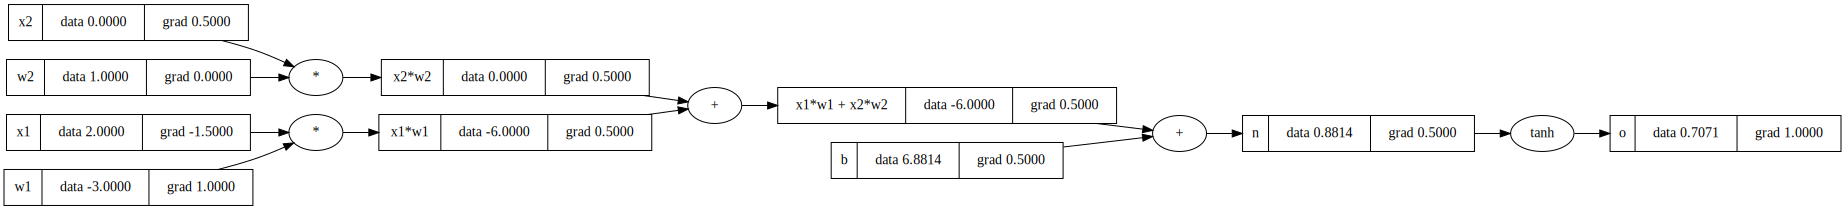

In [12]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()
draw_graph(o)

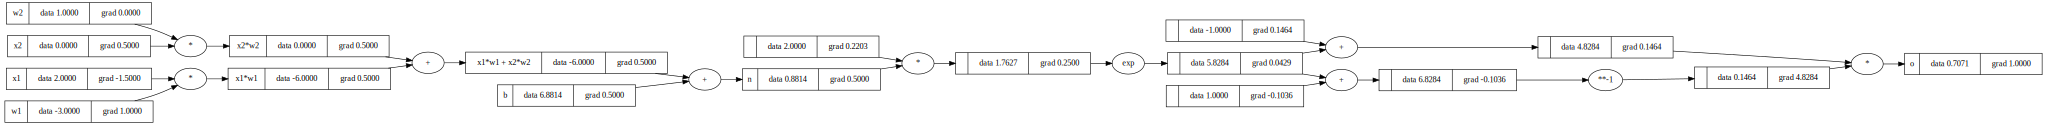

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_graph(o)